## Data preprocessing

In [2]:
import argparse
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from utils.GNN_data import *
from utils.GNN_model import GIN
from utils.train_model import train_model
from utils.evaluate_model import *

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('--batch_num', type=int, default=64, help='batch size') 
parser.add_argument('--epoch_num', type=int, default=200, help='Epoch number') 
parser.add_argument('--cover_interval', type=int, default=20, help='Cover interval')
parser.add_argument('--overlap', type=float, default=0.3, help='cover overlap')
parser.add_argument('--save_model_dir', type=str, default='./examples/saved_GNN_model', help='saved GNN model directory')
args = parser.parse_args([])

In [4]:
from torch_geometric.data import Data
import torch 
def load_inp_data(file_path, label):
    nodes, edges = [], []
    
    with open(file_path, 'r') as file:
        lines = file.readlines()

        node_section = False
        element_section = False

        for line in lines:
            line = line.strip()

            if "*Node" in line:
                node_section = True
                element_section = False
                continue

            if "*Element" in line:
                node_section = False
                element_section = True
                continue

            # Skip invalid lines like "*Nset" or "*Elset"
            if "*Nset" in line or "*Elset" in line:
                node_section = False
                element_section = False
                continue

            if node_section:
                parts = line.split(',')
                if len(parts) >= 3:
                    try:
                        x, y = float(parts[1].strip()), float(parts[2].strip())
                        nodes.append([x, y])
                    except ValueError:
                        continue

            if element_section:
                parts = line.split(',')
                if len(parts) >= 3 and parts[0].strip().isdigit() and parts[1].strip().isdigit() and parts[2].strip().isdigit():
                    start, end = int(parts[1].strip()) - 1, int(parts[2].strip()) - 1  # Convert 1-indexed to 0-indexed
                    
                    if start == end:
                        continue
                    
                    # Ensure indices are within valid range
                    if start < len(nodes) and end < len(nodes):
                        edges.append([start, end])
                    else:
                        print(f"Skipping invalid edge ({start+1}, {end+1}) in {file_path}")

    node_tensor = torch.tensor(nodes, dtype=torch.float)
    edge_tensor = torch.tensor(edges, dtype=torch.long).t().contiguous() if edges else torch.empty((2, 0), dtype=torch.long)

    data = Data(x=node_tensor, edge_index=edge_tensor, K=np.float64(label * 200000.00))
    return data

# Data loading

In [5]:
import glob

# Read the Result.txt file and extract filenames and their labels
file_labels = {}
with open('Results.txt', 'r') as file:
    for line in file:
        # Skip empty lines or lines starting with a header
        if line.strip() == "" or "E/Es" in line:
            continue
        
        try:
            file, label = line.strip().split(', ')
            filename, filetype = file.strip().split('.')
            label = float(label)  # Convert the label to a float
            file_labels[filename] = label
        except ValueError:
            print(f"Skipping line due to invalid format: {line.strip()}")

# Load all data points using the filenames and labels from the file_labels dictionary
dataset = [load_inp_data(f"inp_files/{file}.inp", label) for file, label in file_labels.items()]

# Print out the loaded data
for file, label in file_labels.items():
    print(f"Filename: {file}, E/Es: {label}")

Filename: Demi-C10L_R00_n01, E/Es: 0.0129984714329
Filename: Demi-C10L_R01_n01, E/Es: 0.0129799015095
Filename: Demi-C10L_R01_n02, E/Es: 0.012882332694
Filename: Demi-C10L_R01_n03, E/Es: 0.0129541054904
Filename: Demi-C10L_R01_n04, E/Es: 0.012946272263
Filename: Demi-C10L_R01_n05, E/Es: 0.0129224043358
Filename: Demi-C10L_R01_n06, E/Es: 0.0129640962546
Filename: Demi-C10L_R01_n07, E/Es: 0.0129456131992
Filename: Demi-C10L_R01_n08, E/Es: 0.012987821605
Filename: Demi-C10L_R01_n09, E/Es: 0.0129728170464
Filename: Demi-C10L_R01_n10, E/Es: 0.0129336924547
Filename: Demi-C10L_R01_n11, E/Es: 0.0129515117253
Filename: Demi-C10L_R01_n12, E/Es: 0.0129542867802
Filename: Demi-C10L_R01_n13, E/Es: 0.0128896126101
Filename: Demi-C10L_R01_n14, E/Es: 0.012953438873
Filename: Demi-C10L_R01_n15, E/Es: 0.0129888451366
Filename: Demi-C10L_R01_n16, E/Es: 0.0129720597841
Filename: Demi-C10L_R01_n17, E/Es: 0.0129488905778
Filename: Demi-C10L_R01_n18, E/Es: 0.0129692006938
Filename: Demi-C10L_R01_n19, E/Es: 

In [6]:
dataset

[Data(x=[165, 2], edge_index=[2, 324], K=2599.69428658),
 Data(x=[165, 2], edge_index=[2, 324], K=2595.9803019),
 Data(x=[165, 2], edge_index=[2, 324], K=2576.4665388),
 Data(x=[165, 2], edge_index=[2, 324], K=2590.82109808),
 Data(x=[165, 2], edge_index=[2, 324], K=2589.2544526),
 Data(x=[165, 2], edge_index=[2, 324], K=2584.4808671600003),
 Data(x=[165, 2], edge_index=[2, 324], K=2592.8192509200003),
 Data(x=[165, 2], edge_index=[2, 324], K=2589.12263984),
 Data(x=[165, 2], edge_index=[2, 324], K=2597.564321),
 Data(x=[165, 2], edge_index=[2, 324], K=2594.56340928),
 Data(x=[165, 2], edge_index=[2, 324], K=2586.73849094),
 Data(x=[165, 2], edge_index=[2, 324], K=2590.30234506),
 Data(x=[165, 2], edge_index=[2, 324], K=2590.85735604),
 Data(x=[165, 2], edge_index=[2, 324], K=2577.92252202),
 Data(x=[165, 2], edge_index=[2, 324], K=2590.6877746),
 Data(x=[165, 2], edge_index=[2, 324], K=2597.76902732),
 Data(x=[165, 2], edge_index=[2, 324], K=2594.41195682),
 Data(x=[165, 2], edge_inde

In [7]:
batch_size = args.batch_num
epoch_num = args.epoch_num 
learning_rate = 0.005
overlap=args.overlap

normalize_planar_info(dataset)

# Split dataset for train/validation/test
train_loader, test_loader, valid_loader = prepare_dataset(dataset, batch_size, train_percentage=0.80, test_percentage=0.1)

Number of training graphs: 800
Number of test graphs: 100
Number of vali graphs: 101


In [8]:
dataset[12].K

np.float64(2590.85735604)

# GNN architecture

In [9]:
# Define the model, optimizer, and loss function

no_node_feature = dataset[0].x.shape[1]
model = GIN(dim_h=16, node_feature=no_node_feature)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
criterion = nn.MSELoss()
print(model)

# Define a learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

# Use GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_params = sum(p.numel() for p in model.parameters())
print("Number of parameters:", num_params)

GIN(
  (conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): ReLU()
  ))
  (conv2): GINConv(nn=Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): ReLU()
  ))
  (conv3): GINConv(nn=Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): ReLU()
  ))
  (lin1): Linear(in_features=48, out_features=32, bias=True)
  (lin2): Linear(in_features=32, out_features=32, bias=True)
  (lin4): Linear(in_features=32, o

/root/miniconda3/envs/GNN_ElasticModulus_Prediction/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## Training

In [10]:
train_losses, test_losses, R2_trainings, R2_tests, train_acc_total, test_acc_total, best_state_dict = train_model(
    model, train_loader, test_loader, criterion, optimizer, scheduler, device=device, num_epochs=epoch_num)

Epoch [1], Loss[Train: 3012411.875, Test: 1991547.910], R2[Train: -14.088, Test: -9.012], Acc[Train: 9.83, Test: 30.70]
Epoch [2], Loss[Train: 2912843.171, Test: 192506.581], R2[Train: -13.589, Test: 0.032], Acc[Train: 9.86, Test: 54.03]
Epoch [3], Loss[Train: 262097.677, Test: 202217.766], R2[Train: -0.313, Test: -0.017], Acc[Train: 31.55, Test: 62.19]
Epoch [4], Loss[Train: 201627.930, Test: 194388.848], R2[Train: -0.010, Test: 0.023], Acc[Train: 42.84, Test: 66.17]
Epoch [5], Loss[Train: 201534.966, Test: 192655.473], R2[Train: -0.009, Test: 0.031], Acc[Train: 49.59, Test: 68.48]
Epoch [6], Loss[Train: 221741.376, Test: 230875.022], R2[Train: -0.111, Test: -0.161], Acc[Train: 53.87, Test: 69.42]
Epoch [7], Loss[Train: 248736.961, Test: 201826.906], R2[Train: -0.246, Test: -0.015], Acc[Train: 57.07, Test: 70.41]
Epoch [8], Loss[Train: 218745.453, Test: 203980.448], R2[Train: -0.096, Test: -0.025], Acc[Train: 59.46, Test: 71.13]
Epoch [9], Loss[Train: 203226.997, Test: 191233.538], R2

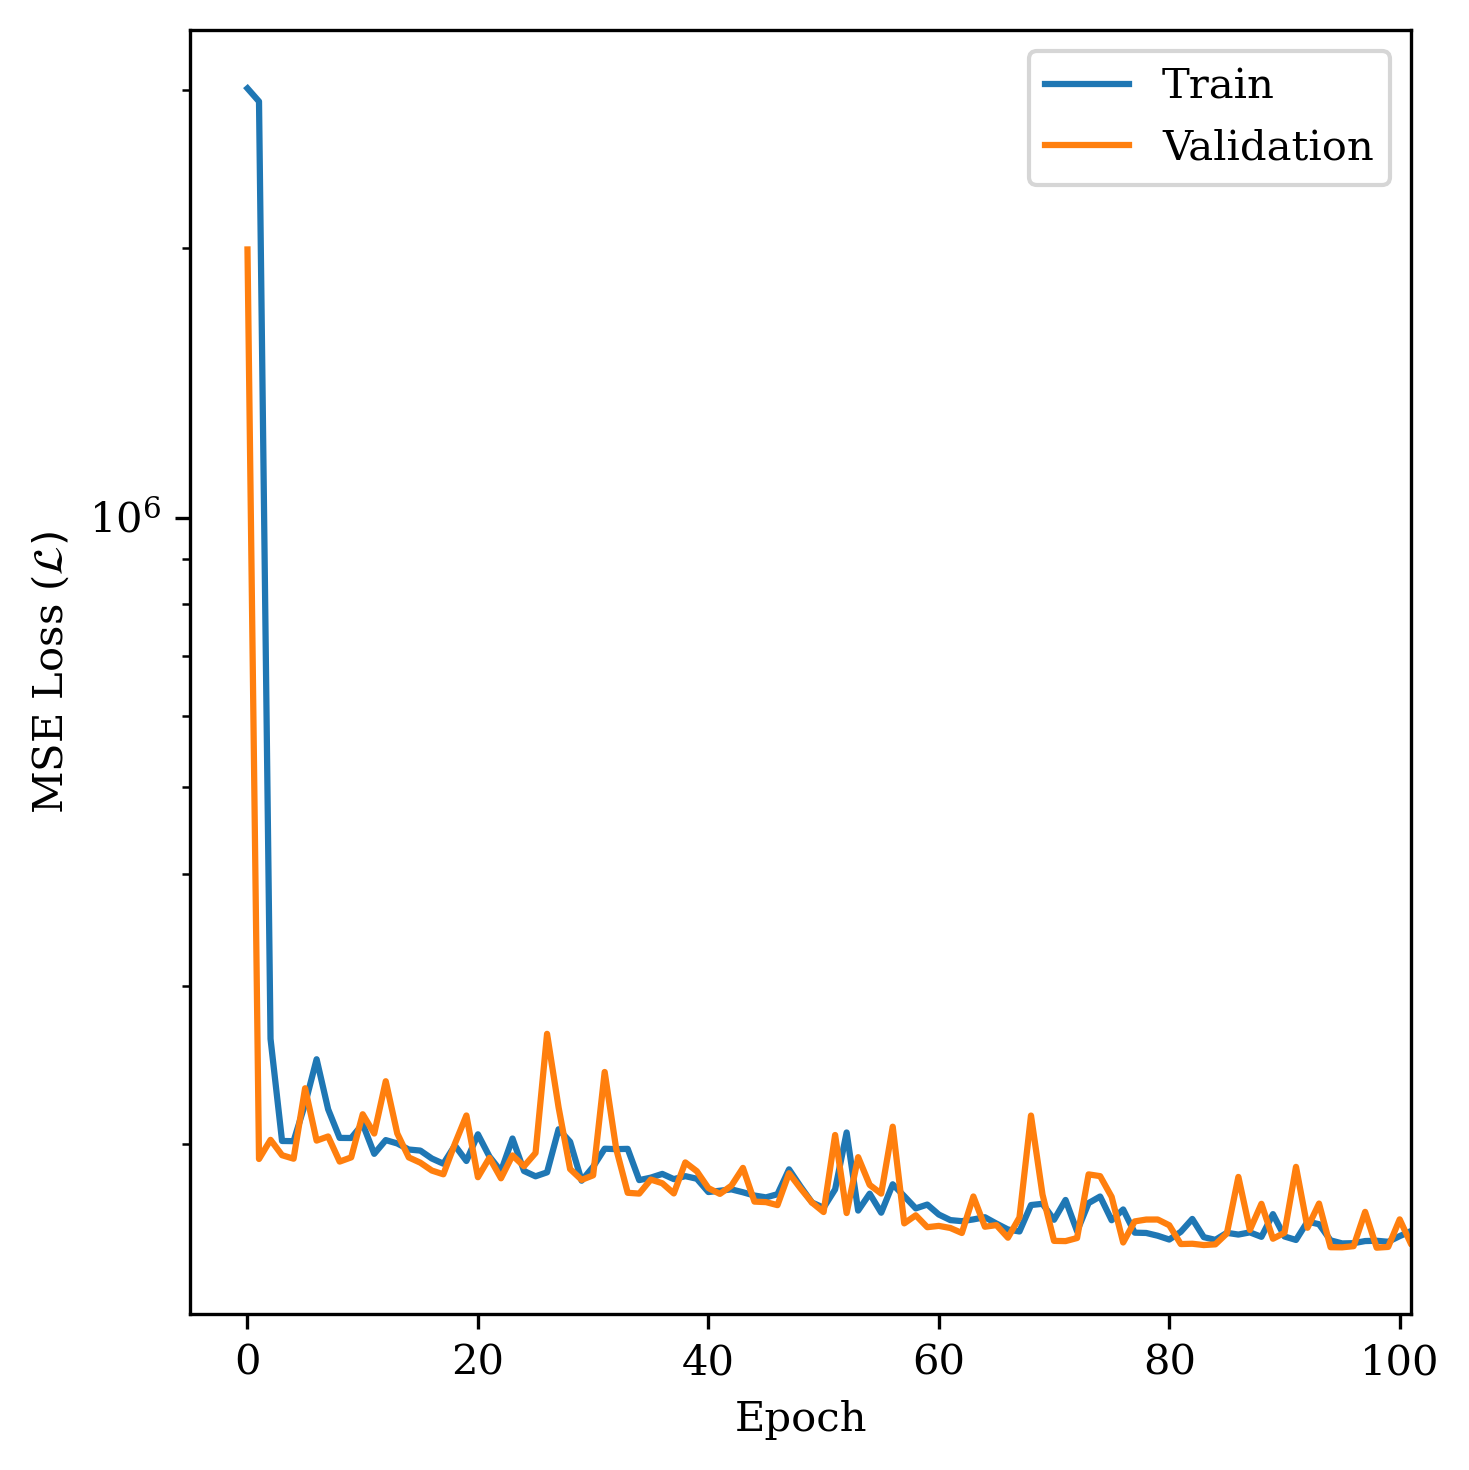

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# 1) Epoch vs R^2
plt.figure(dpi=300, figsize=(5,5)) 

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 10

plt.plot(np.array(train_losses), label='Train')
plt.plot(np.array(test_losses), label='Validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel(r'MSE Loss ($\mathcal{L})$')
plt.yscale("log") 
plt.xlim(-5,101)
plt.tight_layout() 

# Save model

In [12]:
best_model_path = f'{args.save_model_dir}/epoch_{args.epoch_num}.pt'  
torch.save(best_state_dict, best_model_path)

# Evaluation

Test R2 for E: 0.29758328199386597
Accuracy for E 77.48539


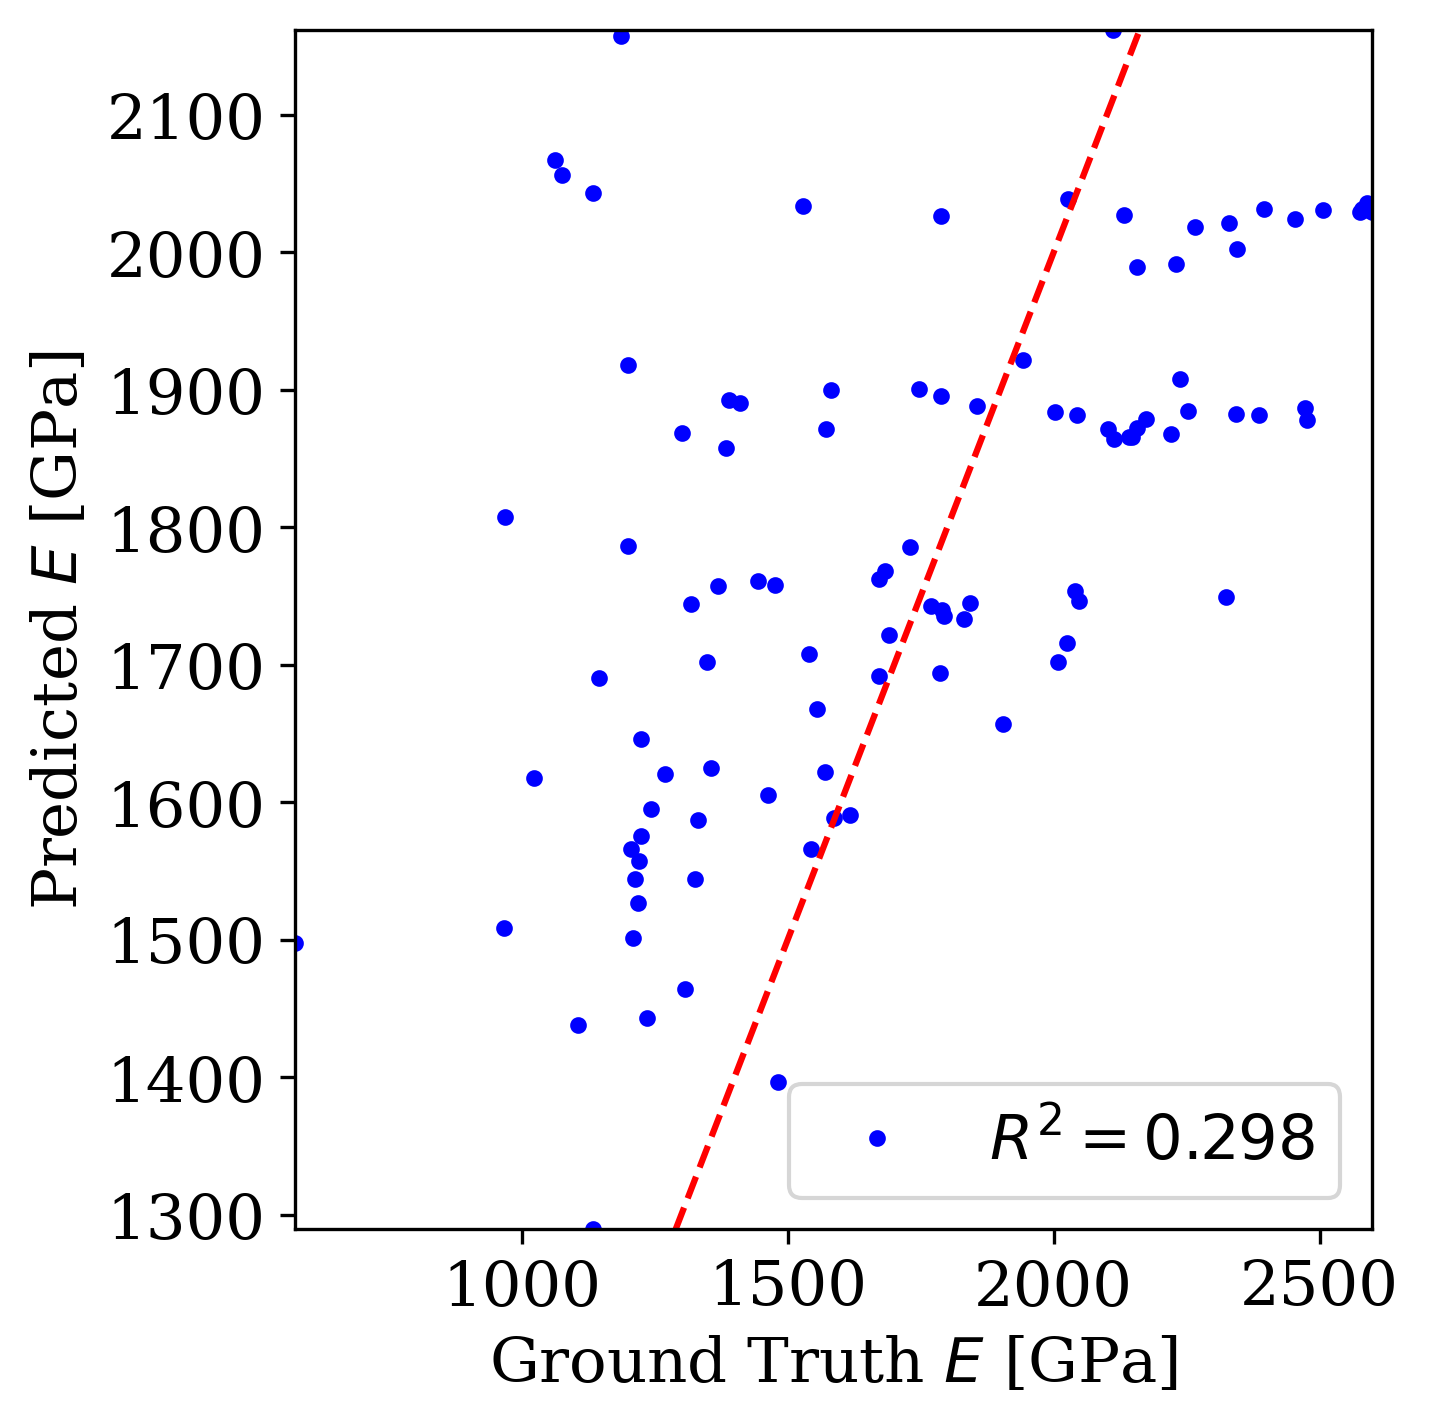

In [13]:
R2_K = evaluate_model(model, valid_loader, device, args.cover_interval, overlap, args.save_model_dir)